In [1]:
import xarray as xr

# Load the SINMOD NetCDF file
sinmod_file = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'
temp_file = 'processed_data/features/temperature_bottom_features.nc'
salinity_file = 'processed_data/features/salinity_bottom_features.nc'
current_speed_file = 'processed_data/features/current_speed_bottom_features.nc'

ds = xr.open_dataset(sinmod_file)
temp_ds = xr.open_dataset(temp_file)
salinity_ds = xr.open_dataset(salinity_file)
current_speed_ds = xr.open_dataset(current_speed_file)

SINMOD_features = xr.Dataset({
    'bottom_temperature_features': temp_ds["temperature_features"],
    'bottom_salinity_features': salinity_ds["salinity_features"],
    'bottom_current_features': current_speed_ds["current_speed_features"]
})

temp_ds.close()
salinity_ds.close()
current_speed_ds.close()

SINMOD_features = SINMOD_features.reset_coords(drop=True)

print(SINMOD_features)

<xarray.Dataset> Size: 19MB
Dimensions:                      (xc: 950, yc: 555, stat: 3)
Coordinates:
  * xc                           (xc) float32 4kB 800.0 1.6e+03 ... 7.6e+05
  * yc                           (yc) float32 2kB 800.0 1.6e+03 ... 4.44e+05
  * stat                         (stat) <U15 180B 'mean' ... '90th_percentile'
Data variables:
    bottom_temperature_features  (stat, yc, xc) float32 6MB ...
    bottom_salinity_features     (stat, yc, xc) float32 6MB ...
    bottom_current_features      (stat, yc, xc) float32 6MB ...


In [2]:
import rasterio

# Open a TIFF file to extract resolution and bounds

tif_file = 'raw_data/EMOD-tifs/C5_2022_mean_UTM_32_resam.tif'

with rasterio.open(tif_file) as tif:
    target_crs = tif.crs  # EPSG:32632
    target_bounds = tif.bounds
    target_transform = tif.transform
    target_resolution = tif.res
    print(f"Target CRS: {target_crs}, Bounds: {target_bounds}, Resolution: {target_resolution}")


Target CRS: EPSG:32632, Bounds: BoundingBox(left=109798.28607731192, bottom=6812340.081526826, right=830804.4917635358, top=7965849.508304196), Resolution: (111.06072176312752, 87.50640470166668)


In [3]:
from pyproj import CRS

def obtain_sinmod_crs(PhysStates_data):
    # Access grid mapping attributes from the dataset
    grid_mapping = PhysStates_data['grid_mapping']  # Replace 'grid_mapping' with the correct variable name if different
    grid_attrs = grid_mapping.attrs  # Get the attributes of the grid mapping

    # Print horizontal resolution if available
    horizontal_resolution = grid_attrs.get('horizontal_resolution', 'unknown')
    print(f"\nHorizontal resolution: {horizontal_resolution} meters")

    # Construct the CRS using the attributes
    crs_sinmod = CRS.from_proj4(
        f"+proj=stere "
        f"+lat_0={grid_attrs['latitude_of_projection_origin']} "
        f"+lat_ts={grid_attrs['standard_parallel']} "
        f"+lon_0={grid_attrs['straight_vertical_longitude_from_pole']} "
        f"+x_0={grid_attrs['false_easting']} "
        f"+y_0={grid_attrs['false_northing']} "
        f"+a={grid_attrs['semi_major_axis']} "
        f"+b={grid_attrs['semi_minor_axis']} "
        f"+units=m +no_defs"
    )

    print(f"\nDetermined SINMOD CRS: {crs_sinmod}")
    return crs_sinmod

midnor_crs = obtain_sinmod_crs(ds)

# Attach the CRS to the SINMOD dataset
SINMOD_features = SINMOD_features.rio.write_crs(midnor_crs)


Horizontal resolution: 800.0 meters

Determined SINMOD CRS: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=58.0 +x_0=2544800.0 +y_0=1918800.0 +a=6370000.0 +b=6370000.0 +units=m +no_defs +type=crs


In [5]:
import rioxarray
from rasterio.enums import Resampling

# Reproject to match the TIFF CRS
SINMOD_features_reprojected = SINMOD_features.rio.reproject(
    dst_crs=target_crs.to_string(),
    resolution=target_resolution,  # Match TIFF resolution
    resampling=Resampling.bilinear  # Use 'nearest' for categorical variables
)

# Inspect reprojected data
print(SINMOD_features_reprojected)

<xarray.Dataset> Size: 3GB
Dimensions:                      (x: 7652, y: 10085, stat: 3)
Coordinates:
  * x                            (x) float64 61kB -6.548e+04 ... 7.842e+05
  * y                            (y) float64 81kB 7.539e+06 ... 6.657e+06
  * stat                         (stat) <U15 180B 'mean' ... '90th_percentile'
    spatial_ref                  int64 8B 0
Data variables:
    bottom_temperature_features  (stat, y, x) float32 926MB nan nan ... nan nan
    bottom_salinity_features     (stat, y, x) float32 926MB nan nan ... nan nan
    bottom_current_features      (stat, y, x) float32 926MB nan nan ... nan nan


In [10]:
# Saving the reprojected data

output_file = 'processed_data/features/SINMOD_bottom_features_reprojected.nc'

SINMOD_features_reprojected.to_netcdf(output_file)

# Save one layer as tif: Mean temperature
data_to_save = SINMOD_features_reprojected['bottom_temperature_features'].isel(stat=0)

# Set CRS (if not already set)
data_to_save.rio.write_crs("EPSG:32632", inplace=True)

# Set the affine transform (example)
# Use the transform from your dataset (target_transform)
data_to_save.rio.write_transform(target_transform, inplace=True)

# Save the data to a GeoTIFF
output_tif = 'processed_data/features/bottom_temperature_reprojected.tif'
data_to_save.rio.to_raster(output_tif)

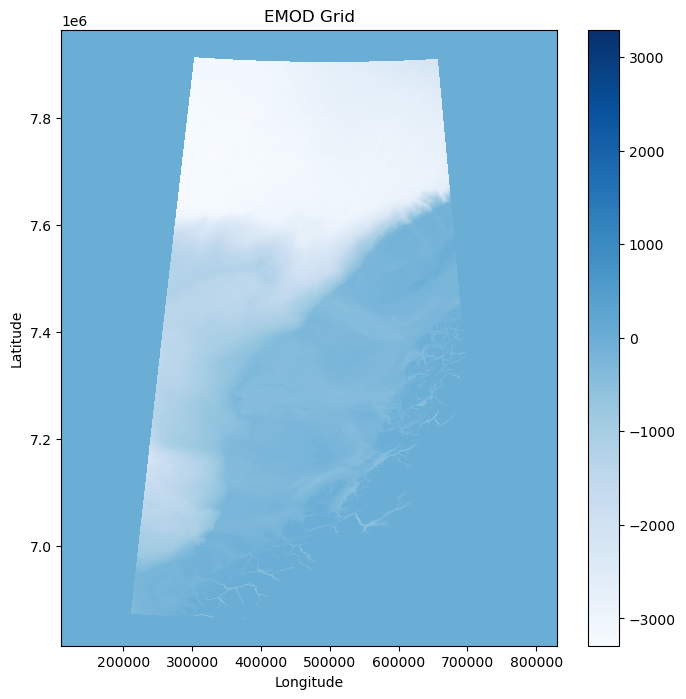

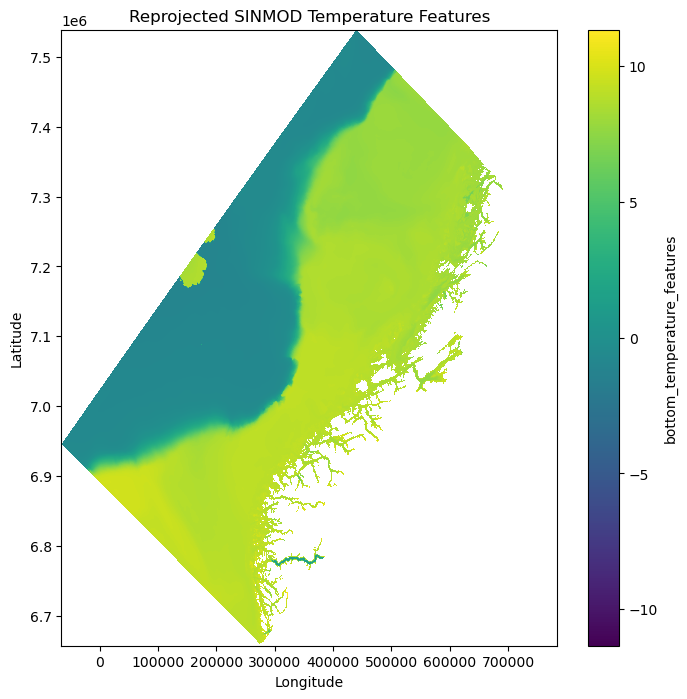

In [ ]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import rasterio

# Load the reprojected SINMOD dataset
# SINMOD_features_reprojected = xr.open_dataset('processed_data/features/SINMOD_features_reprojected.nc')

# Load the EMOD grid as a reference (e.g., temperature)
emod_grid = rioxarray.open_rasterio(tif_file)

# Plotting the EMOD grid
fig, ax = plt.subplots(figsize=(8, 8))
emod_grid.plot(ax=ax, cmap='Blues')
ax.set_title('EMOD Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting the reprojected SINMOD data (bottom_temperature, for example)
fig, ax = plt.subplots(figsize=(8, 8))
SINMOD_features_reprojected['bottom_temperature_features'].isel(stat=0).plot(ax=ax, cmap='viridis')
ax.set_title('Reprojected SINMOD Temperature Features')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

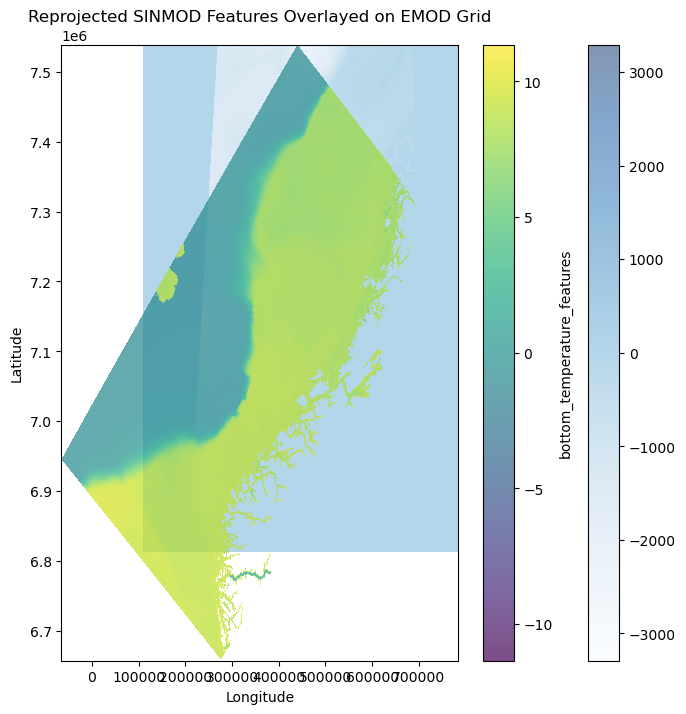

In [8]:
import matplotlib.pyplot as plt 

#Load the EMOD grid as a reference (e.g., temperature)
emod_grid = rioxarray.open_rasterio(tif_file)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the EMOD grid as the background
emod_grid.plot(ax=ax, cmap='Blues', alpha=0.5)  # Transparency for background grid

# Plot the reprojected SINMOD data (bottom_temperature, for example)
SINMOD_features_reprojected['bottom_temperature_features'].isel(stat=0).plot(ax=ax, cmap='viridis', alpha=0.7)

# Add titles and labels
ax.set_title('Reprojected SINMOD Features Overlayed on EMOD Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
from netCDF4 import Dataset

# Cut down each tif to the same grid boundaries as MidNor data
# 1. Get the grid boundaries of MidNor data
filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc'

midnor_PhysStates_data = Dataset(filename_PhysStates, 'r')

# # Looking at our list of available variables
# variables_list = list(midnor_PhysStates_data.variables.keys())
# for variable in variables_list:
#     units = midnor_PhysStates_data.variables[variable].units if 'units' in midnor_PhysStates_data.variables[variable].ncattrs() else 'No units'
#     print(f"{variable:<20} {units}")

# Get the corner points from gridLats and gridLons
gridLats = midnor_PhysStates_data.variables['gridLats'][:]
gridLons = midnor_PhysStates_data.variables['gridLons'][:]

corner_points = {
    'bottom_left': (gridLats[0, 0], gridLons[0, 0]),
    'bottom_right': (gridLats[0, -1], gridLons[0, -1]),
    'top_left': (gridLats[-1, 0], gridLons[-1, 0]),
    'top_right': (gridLats[-1, -1], gridLons[-1, -1])
}

# print("Corner Points:")
# for corner, (lat, lon) in corner_points.items():
#     print(f"{corner}: Latitude = {lat}, Longitude = {lon}")

# Get the corner coordinates in native coordinates using xc and yc
xc = midnor_PhysStates_data.variables['xc'][:]
yc = midnor_PhysStates_data.variables['yc'][:]

native_corner_points = {
    'bottom_left': (xc[0], yc[0]),
    'bottom_right': (xc[0], yc[-1]),
    'top_left': (xc[-1], yc[0]),
    'top_right': (xc[-1], yc[-1])
}

print("\nNative Corner Points:\n")
for corner, (x, y) in native_corner_points.items():
    print(f"{corner}: x = {x}, y = {y}")


Native Corner Points:

bottom_left: x = 800.0, y = 800.0
bottom_right: x = 800.0, y = 444000.0
top_left: x = 760000.0, y = 800.0
top_right: x = 760000.0, y = 444000.0


In [ ]:
from pyproj import CRS, Transformer
import numpy as np
from rasterio import warp

def obtain_sinmod_crs(PhysStates_data):
    # Print grid mapping to see details, particularly the horizontal resolution
    grid_mapping = PhysStates_data.variables['grid_mapping']
    print(grid_mapping)

    horizontal_resolution = grid_mapping.getncattr('horizontal_resolution')
    print(f"\nHorizontal resolution: {horizontal_resolution} meters")

    crs_sinmod = CRS.from_proj4(f"+proj=stere "
                                f"+lat_0={grid_mapping.latitude_of_projection_origin} "
                                f"+lat_ts={grid_mapping.standard_parallel} "
                                f"+lon_0={grid_mapping.straight_vertical_longitude_from_pole} "
                                f"+x_0={grid_mapping.false_easting} "
                                f"+y_0={grid_mapping.false_northing} "
                                f"+a={grid_mapping.semi_major_axis} "
                                f"+b={grid_mapping.semi_minor_axis} "
                                f"+units=m +no_defs")
    
    print(f"\n Determined SINMOD CRS: {crs_sinmod}")
    return crs_sinmod

def transform_coral_coordinates(coral_data, crs_sinmod):
    # Define the Coordinate Reference Systems (CRS) for the coral data
    crs_wgs84 = CRS.from_epsg(4326)  # WGS84 (lat/lon coordinates)

    # Create a transformer to transform from wgs84 (geographic) to SINMOD
    transformer_wgs84_to_sinmod = Transformer.from_crs(crs_wgs84, crs_sinmod, always_xy=True)

    # Transform coral coordinates from WGS84 to SINMOD
    coral_x, coral_y = transformer_wgs84_to_sinmod.transform(coral_data['lengdegrad'], coral_data['breddegrad'])

    # Save coral_x and coral_y as new columns called x and y
    coral_data.loc[:, 'x'] = coral_x
    coral_data.loc[:, 'y'] = coral_y

    return coral_data

def transform_tif_coordinates(tif_data, crs_sinmod, transform):
    # Define the Coordinate Reference Systems (CRS) for the tif data
    crs_tif = CRS.from_epsg(32632)  # UTM Zone 32N

    # Create a transformer to transform from UTM Zone 32N to SINMOD
    transformer_tif_to_sinmod = Transformer.from_crs(crs_tif, crs_sinmod, always_xy=True)

    # Get the coordinates of the tif data
    rows, cols = tif_data.shape
    x_coords, y_coords = rasterio.transform.xy(transform, np.arange(rows), np.arange(cols), offset='center')

    # Transform tif coordinates from UTM Zone 32N to SINMOD
    tif_x, tif_y = transformer_tif_to_sinmod.transform(x_coords, y_coords)

    return tif_x, tif_y

def transform_raster_to_crs(input_tif, output_tif, target_crs):
    """
    Transforms a GeoTIFF file's coordinates to a specified CRS.
    
    Parameters:
        input_tif (str): Path to the input GeoTIFF file.
        output_tif (str): Path to save the transformed GeoTIFF file.
        target_crs (str): Target CRS in WKT or EPSG format (e.g., 'EPSG:3413').
    """
    with rasterio.open(input_tif) as src:
        # Define the transformer
        transformer = Transformer.from_crs(src.crs, target_crs, always_xy=True)

        # Transform the bounding box coordinates
        bounds = src.bounds
        corners = [
            (bounds.left, bounds.bottom),  # Bottom-left
            (bounds.right, bounds.top)    # Top-right
        ]
        transformed_corners = [transformer.transform(x, y) for x, y in corners]
        print(f"Transformed corners: {transformed_corners}")

        # Get the new bounds
        new_left, new_bottom = transformed_corners[0]
        new_right, new_top = transformed_corners[1]

        # Update the transform and metadata for the new CRS
        new_transform, new_width, new_height = rasterio.warp.calculate_default_transform(
            src.crs, target_crs, src.width, src.height, left=new_left, bottom=new_bottom, right=new_right, top=new_top
        )

        # Update metadata
        new_meta = src.meta.copy()
        new_meta.update({
            "crs": target_crs,
            "transform": new_transform,
            "width": new_width,
            "height": new_height
        })

        # Write the transformed raster to the output file
        with rasterio.open(output_tif, "w", **new_meta) as dst:
            rasterio.warp.reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=new_transform,
                dst_crs=target_crs,
                resampling=rasterio.warp.Resampling.nearest
            )


In [ ]:
midnor_crs = obtain_sinmod_crs(midnor_PhysStates_data)

transform_raster_to_crs('raw_data/EMOD-tifs/C5_slope.tif', 'processed_data/tifs/C5_slope_transformed.tif', midnor_crs)

<class 'netCDF4._netCDF4.Variable'>
int32 grid_mapping()
    grid_mapping_name: polar_stereographic
    straight_vertical_longitude_from_pole: 58.0
    horizontal_resolution: 800.0
    latitude_of_projection_origin: 90.0
    longitude_of_projection_origin: 58.0
    standard_parallel: 60.0
    origoRef: [0. 0.]
    semi_minor_axis: 6370000.0
    semi_major_axis: 6370000.0
    false_easting: 2544800.0
    false_northing: 1918800.0
    scale_factor_at_projection_origin: 1.0
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

Horizontal resolution: 800.0 meters

 Determined SINMOD CRS: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=58.0 +x_0=2544800.0 +y_0=1918800.0 +a=6370000.0 +b=6370000.0 +units=m +no_defs +type=crs
Transformed corners: [(111322.95730004925, 181891.28435119358), (1214916.3274095315, 471715.03834121255)]


In [ ]:
slope_transformed = rasterio.open('raw_data/EMOD-tifs/C5_slope_transformed.tif')

slope_transformed.width

12341